# **Business Overview:**
In this project, we aim to forecast daily sales for the next 28 days for Walmart. The data, covers stores in three US States (California, Texas, and Wisconsin) and includes item level, department, product categories, and store details. In addition, it has explanatory variables such as price, promotions, day of the week, and special events. Together, this robust dataset can be used to improve forecasting accuracy.

**We begin with Data Explotration**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import dates as mat_dates
from matplotlib.ticker import FuncFormatter, PercentFormatter
import math
pd.options.mode.chained_assignment = None
pd.set_option('display.float_format', '{:.2f}'.format)

In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/m5-forecasting-accuracy/calendar.csv
/kaggle/input/m5-forecasting-accuracy/sample_submission.csv
/kaggle/input/m5-forecasting-accuracy/sell_prices.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_validation.csv
/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv


In [4]:
calendar_df=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/calendar.csv")

In [5]:
sales_df=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sales_train_evaluation.csv")
prices_df=pd.read_csv("/kaggle/input/m5-forecasting-accuracy/sell_prices.csv")

In [6]:
print('shape of calendar_df is ',calendar_df.shape)
print('top 2 rows of calendar_df')
calendar_df.head(2)

shape of calendar_df is  (1969, 14)
top 2 rows of calendar_df


,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0


In [7]:
print('shape of sales_df is ',sales_df.shape)
print('top 2 rows of sales_df')
sales_df.head(2)

shape of sales_df is  (30490, 1947)
top 2 rows of sales_df


,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0


In [8]:
print('shape of prices_df is ',prices_df.shape)
print('top 2 rows of prices_df')
prices_df.head(2)

shape of prices_df is  (6841121, 4)
top 2 rows of prices_df


,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58


In [9]:
states = len(sales_df['state_id'].unique())
stores = len(sales_df['store_id'].unique())
item_cat = len(sales_df['cat_id'].unique())
depts = len(sales_df['dept_id'].unique())
items = len(sales_df['item_id'].unique())
f'The data comprises for {states} States, {stores} Stores, {item_cat} Item Categories, {depts} Departments, {items} Items'

'The data comprises for 3 States, 10 Stores, 3 Item Categories, 7 Departments, 3049 Items'

**Overall sales from day 1 (Jan 29 2011) to day 1913 (Apr 24 2016) i.e, approximately for 5.5 years:**

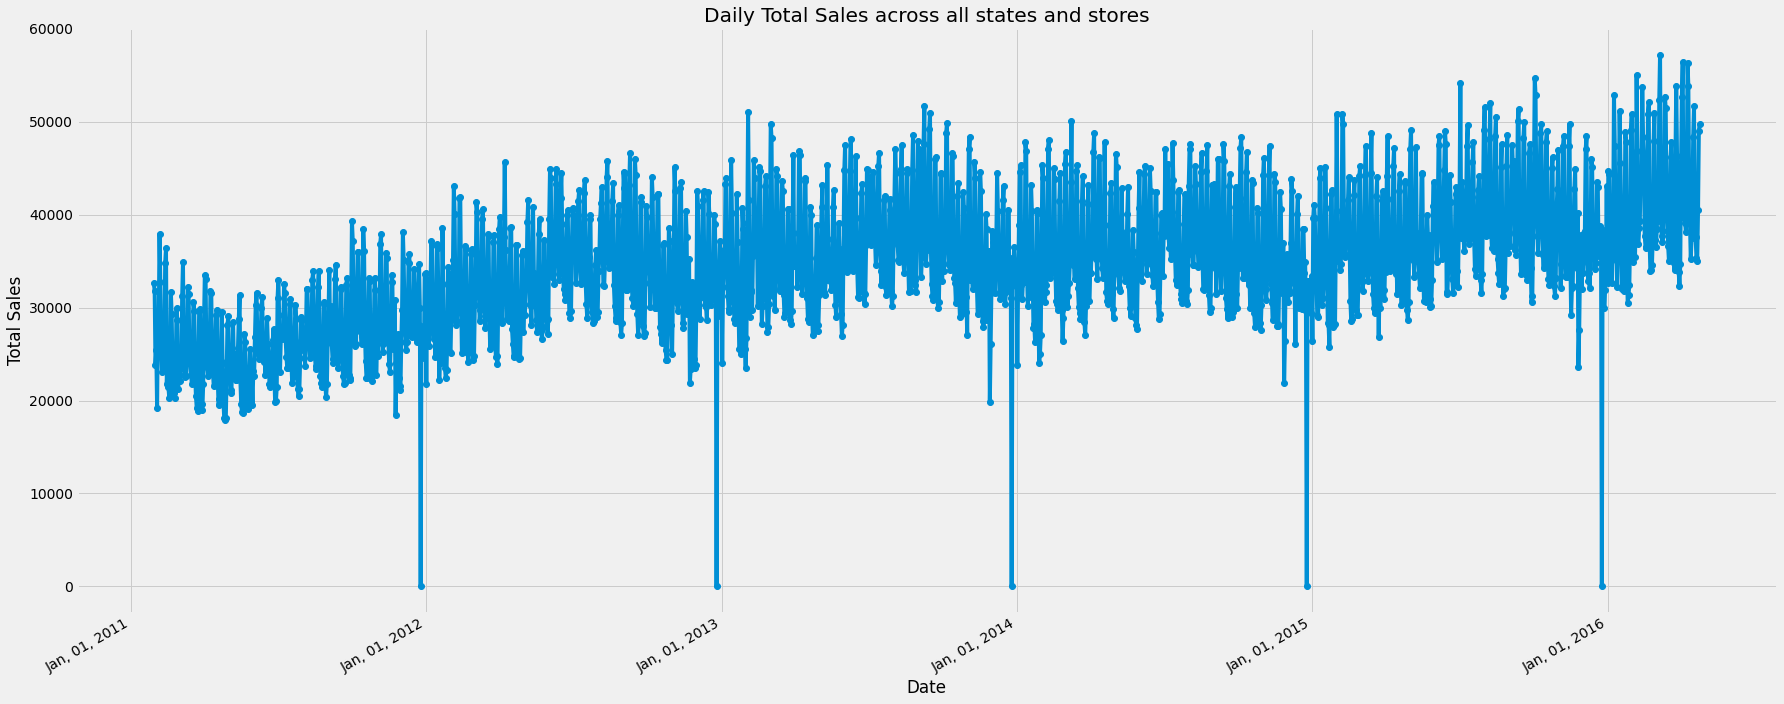

In [11]:

daily_overallsales = sales_df.loc[:,'d_1':'d_1913'].aggregate(['sum'])
daily_overallsales = daily_overallsales.T.reset_index()
daily_overallsales.rename(columns={'sum':'Total_Sales','index':'d'}, inplace=True)
daily_overallsales = daily_overallsales.merge(calendar_df,on='d',how='left')
daily_overallsales = daily_overallsales[['date','Total_Sales']]
daily_overallsales['date'] = pd.to_datetime(daily_overallsales['date'])
daily_dates = daily_overallsales['date']
daily_totalSales = daily_overallsales['Total_Sales']

""" Plot of Date Vs Total_sales """
plt.style.use('fivethirtyeight')
plt.plot_date(daily_dates,daily_totalSales,linestyle='solid')
plt.gcf().autofmt_xdate()
date_format = mat_dates.DateFormatter('%b, %d, %Y')
plt.gca().xaxis.set_major_formatter(date_format)
plt.gcf().set_size_inches(25, 10)
plt.title('Daily Total Sales across all states and stores')
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

**Overall sales for each year from 2011-2016:**

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  if sys.path[0] == "":


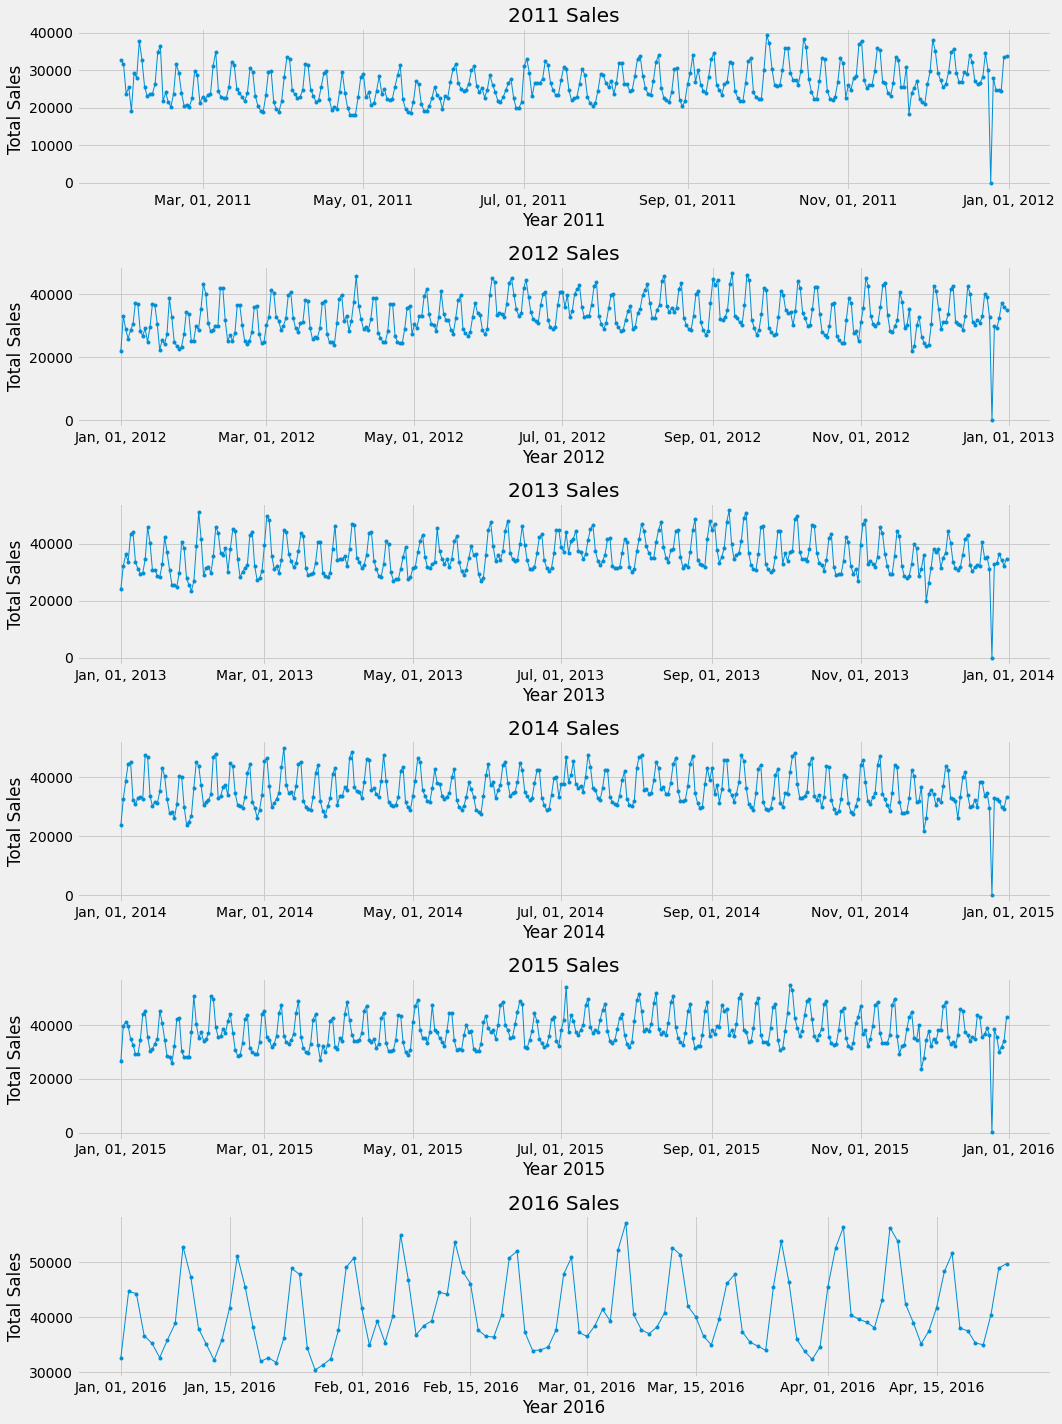

In [13]:

daily_overallsales['year'] = daily_overallsales['date'].dt.year
daily_overallsales_grp = daily_overallsales.groupby(['year'])
gf = daily_overallsales_grp.groups

""" plot of Years Vs Total_sales """
gf_val_lst = list(gf.values())
date_format = mat_dates.DateFormatter('%b, %d, %Y')
fig = plt.figure(figsize=(15, 20))
for i in range(6):
    ax = fig.add_subplot(6,1,i+1)
    plt.plot_date(daily_overallsales.iloc[gf_val_lst[i]]['date'],daily_overallsales.iloc[gf_val_lst[i]]['Total_Sales'],linestyle='solid',linewidth=1,marker='.')
    plt.gca().xaxis.set_major_formatter(date_format)
    plt.gca().set_title(str(2011+i)+ ' Sales')
    plt.gca().set_xlabel('Year '+str(2011+i))
    plt.gca().set_ylabel('Total Sales')
plt.tight_layout()
plt.show()

**Global monthly seasonality sales:**

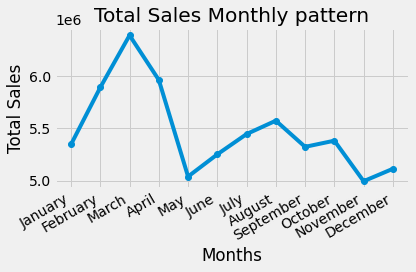

In [14]:
daily_overallsales['month']=daily_overallsales['date'].dt.month_name()
daily_overallsales_gpm = daily_overallsales.groupby('month').agg({'Total_Sales':'sum'}).reset_index()

#reference: https://stackoverflow.com/questions/40816144/pandas-series-sort-by-month-index
months_order = list(daily_overallsales['date'].dt.month_name().unique())
daily_overallsales_gpm.index = pd.CategoricalIndex(daily_overallsales_gpm.month, categories=months_order, ordered=True)
daily_overallsales_gpm = daily_overallsales_gpm.sort_index()
daily_overallsales_gpm.reset_index(drop=True,inplace=True)

"""Plot of Months Vs Total Sales"""
plt.plot_date(daily_overallsales_gpm['month'],daily_overallsales_gpm['Total_Sales'],linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('Total Sales Monthly pattern')
plt.xlabel('Months')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

**Global Weekly Seasonality Sales:**

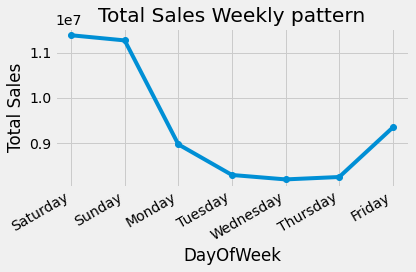

In [15]:
daily_overallsales['day_name']=daily_overallsales['date'].dt.day_name()
daily_overallsales_gpwd = daily_overallsales.groupby('day_name').agg({'Total_Sales':'sum'}).reset_index()

#reference: https://stackoverflow.com/questions/40816144/pandas-series-sort-by-month-index
day_name_order = list(daily_overallsales['date'].dt.day_name().unique())
daily_overallsales_gpwd.index = pd.CategoricalIndex(daily_overallsales_gpwd.day_name, categories=day_name_order, ordered=True)
daily_overallsales_gpwd = daily_overallsales_gpwd.sort_index()
daily_overallsales_gpwd.reset_index(drop=True,inplace=True)

"""Plot of Dayofweek Vs Total Sales"""
plt.plot_date(daily_overallsales_gpwd['day_name'],daily_overallsales_gpwd['Total_Sales'],linestyle='solid')
plt.gcf().autofmt_xdate()
plt.title('Total Sales Weekly pattern')
plt.xlabel('DayOfWeek')
plt.ylabel('Total Sales')
plt.tight_layout()
plt.show()

In [20]:
def add_value_label(x_list,y_list):
    for i in range(1, len(x_list)+1):
        plt.text(i,y_list[i-1],y_list[i-1], ha="center")

**Sales Proportion from each store:**

In [16]:

sales_store_grp = sales_df.groupby('store_id')
sales_store_grp_idx = list(sales_store_grp.groups.values())
stores_ky = list(sales_store_grp.groups.keys())
stores = []
store_sales = []
for i in range(len(stores_ky)):
    stores.append(stores_ky[i])
    store_df = sales_df.iloc[sales_store_grp_idx[i]]
    store_sales.append(int(store_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))



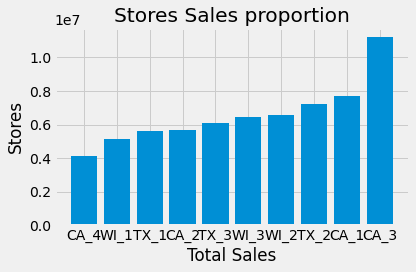

In [17]:

stores = list(np.asarray(stores)[np.argsort(np.asarray(store_sales))])
store_sales = list(np.asarray(store_sales)[np.argsort(np.asarray(store_sales))])
plt.bar(stores,store_sales)
# add_value_label(,store_sales/100000)
plt.title('Stores Sales proportion')
plt.xlabel('Total Sales')
plt.ylabel('Stores')
plt.tight_layout()
plt.show()

**Sales Proportion from each product category:**

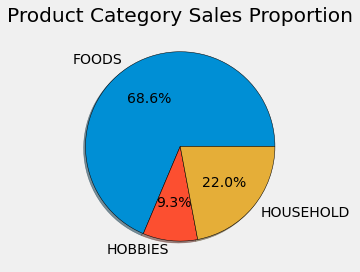

In [18]:
""" Here we get sales Proportion from each product category """
sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
prod_cats = []
prod_cats_sales = []
for i in range(len(cat_ky)):
    prod_cats.append(cat_ky[i])
    cat_df = sales_df.iloc[sales_cat_grp_idx[i]]
    prod_cats_sales.append(int(cat_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))

"""plot of sales Proportion from each product category"""
plt.pie(prod_cats_sales,labels=prod_cats,shadow=True,
        autopct = '%1.1f%%', wedgeprops={'edgecolor':'black'})
plt.title('Product Category Sales Proportion')
plt.tight_layout()
plt.show()

**Sales Proportion from Each Category:**

In [29]:

# sales_dpt_grp = sales_df.groupby('dept_id')
# sales_dpt_grp_idx = list(sales_dpt_grp.groups.values())
# dept_ky = list(sales_dpt_grp.groups.keys())
# depts = []
# dept_sales = []
# for i in range(len(dept_ky)):
#     depts.append(dept_ky[i])
#     dept_df = sales_df.iloc[sales_dpt_grp_idx[i]]
#     dept_sales.append(int(dept_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))



In [24]:
sales_df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,4,0,0,0,0,3,3,0,1
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,1,2,1,1,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,2,0,0,0,2,3,0,1
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,1,0,4,0,1,3,0,2,6
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,2,1,0,0,2,1,0


In [25]:
sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
cats = []
cat_sales = []
for i in range(len(cat_ky)):
    cats.append(cat_ky[i])
    cat_df = sales_df.iloc[sales_cat_grp_idx[i]]
    cat_sales.append(int(dept_df.loc[:,'d_1':'d_1913'].aggregate(['sum']).T.sum().values))

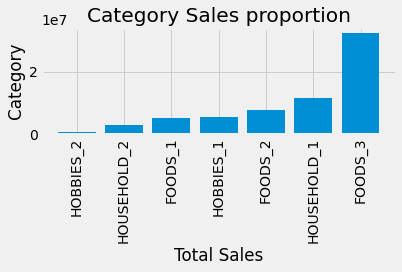

In [28]:
"""plot of sales Proportion from each category"""
cats = list(np.asarray(depts)[np.argsort(np.asarray(dept_sales))])
cat_sales = list(np.asarray(dept_sales)[np.argsort(np.asarray(dept_sales))])
plt.bar(cats,cat_sales)
plt.title('Category Sales proportion')
plt.xlabel('Total Sales')
plt.xticks(rotation = 90)
plt.ylabel('Category')
plt.tight_layout()
plt.show()

In [27]:
# """plot of sales Proportion from each department"""
# depts = list(np.asarray(depts)[np.argsort(np.asarray(dept_sales))])
# dept_sales = list(np.asarray(dept_sales)[np.argsort(np.asarray(dept_sales))])
# plt.bar(depts,dept_sales)
# plt.title('Department Sales proportion')
# plt.xlabel('Total Sales')
# plt.xticks(rotation = 90)
# plt.ylabel('Departments')
# plt.tight_layout()
# plt.show()

**Number of days with and without events:**

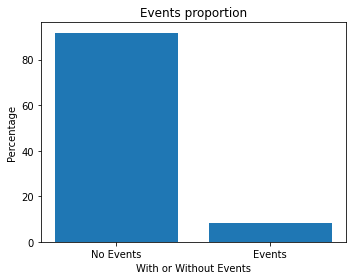

In [7]:

df = calendar_df[['event_name_1']]
no_event_per = ((len(df) - int(df.count()))/len(df))*100
event_per = (int(df.count())/len(df))*100
event_lst = [('No Events',no_event_per),('Events',event_per)]
events = [x[0] for x in event_lst]
events_count = [x[1] for x in event_lst]

plt.figure(figsize=(5,4))
plt.bar(events,events_count)
plt.title('Events proportion')
plt.xlabel('With or Without Events')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

**We have 4 types of events: Religious, National, Cultural and Sporting**

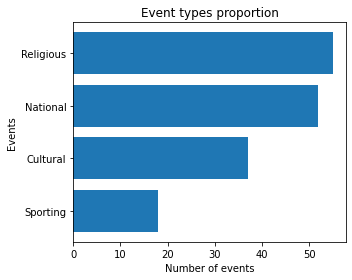

In [8]:

event_lst = [tuple(x) for x in calendar_df[['event_type_1']].value_counts().reset_index().values]
events = [x[0] for x in event_lst]
events.reverse()
events_count = [x[1] for x in event_lst]
events_count.reverse()
plt.figure(figsize=(5,4))
plt.barh(events,events_count)
plt.title('Event types proportion')
plt.xlabel('Number of events')
plt.ylabel('Events')
plt.tight_layout()
plt.show()

**Product Category by Year:**

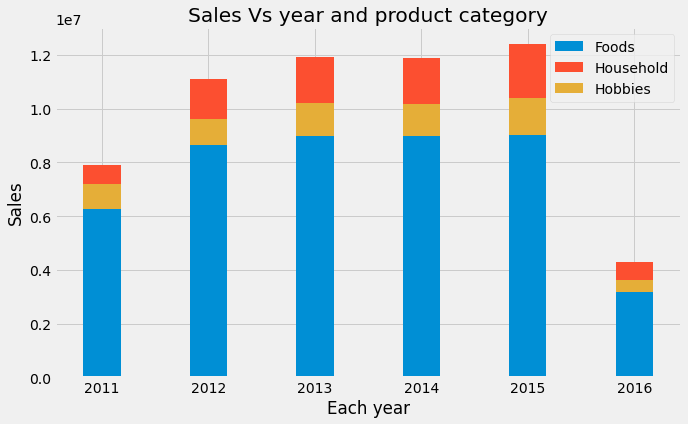

In [9]:
sales_cat = {}
sales_cat_grp = sales_df.groupby('cat_id')
sales_cat_grp_idx = list(sales_cat_grp.groups.values())
cat_ky = list(sales_cat_grp.groups.keys())
for i in range(len(cat_ky)):
    sales_cat_df = pd.melt(sales_df.iloc[sales_cat_grp_idx[i]].loc[:,'d_1':'d_1913'],var_name='d',value_name='sales').merge(calendar_df,on='d',how='left')
    sales_cat_yr_grp = sales_cat_df.groupby('year').groups
    sales_cat_yr_idx = list(sales_cat_yr_grp.values())
    sales_cat_yr_ky = list(sales_cat_yr_grp.keys())
    sales_cat[cat_ky[i]] = {}
    for j in range(len(sales_cat_yr_ky)):
        sales_cat[cat_ky[i]][sales_cat_yr_ky[j]] = sales_cat_df.iloc[sales_cat_yr_idx[j]]['sales'].sum()

"""plot of the sales proportion of each product category for each year """

#https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/bar_stacked.html
N = 6
FOODS_sales = list(sales_cat['FOODS'].values())
HOBBIES_sales = list(sales_cat['HOBBIES'].values())
HOUSEHOLD_sales = list(sales_cat['HOUSEHOLD'].values())

ind = np.arange(N)    
width = 0.35   

plt.style.use('fivethirtyeight')
plt.figure(figsize=(10,6))
p1 = plt.bar(ind, FOODS_sales, width)
p2 = plt.bar(ind, HOUSEHOLD_sales, width,bottom=FOODS_sales)
p3 = plt.bar(ind, HOBBIES_sales, width,bottom=FOODS_sales)

plt.xlabel('Each year')
plt.ylabel('Sales')
plt.title('Sales Vs year and product category')
plt.xticks(ind, (2011, 2012, 2013, 2014, 2015, 2016))
plt.legend((p1[0], p2[0], p3[0]), ('Foods', 'Household','Hobbies'))

plt.show()